Ở buổi học này, chúng ta sẽ làm quen với phép biểu đổi Fourier (DFT, FFT) và thuật toán so sánh chuỗi Dynamic Time Warping(DTW).

# 1. FFT với Python

Để tìm hiểu rõ hơn thuật toán FFT hoạt động như thế nào, các bác có thểm tham khảo thêm [bài viết](http://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/) trên blog của Jake Vanderplas.

Ở đây, chúng ta sẽ tìm hiểu về các ứng dụng của FFT.

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import librosa
import librosa.display
%matplotlib inline

Đầu tiên, hãy xem xét một hàm sóng hình sin đơn giản. Xét tín hiệu có phương trình giao động $y = 100sin(6\pi t)$

In [3]:
t = np.linspace(0, 2*np.pi, 1000, endpoint=True) # các thời điểm lấy mẫu
f = 3.0 # tần số  Hz
A = 100.0 # biên độ
s = A * np.sin(2*np.pi*f*t) # biên độ tại các điểm thời gian lấy mẫu

Trình diễn tín hiệu trên sử dụng **matplotlib**

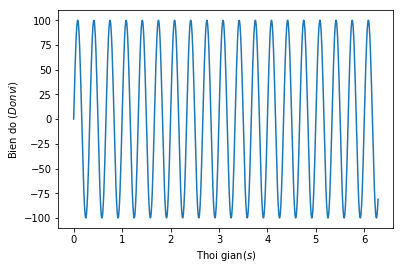

In [4]:
plt.plot(t,s)
plt.xlabel('Thoi gian($s$)')
plt.ylabel('Bien do ($Don vi$)')

Áp dụng biến đổi Fourier vào tín hiệu trên sử dụng phép biến đổi nhanh FFT.

In [5]:
Y = np.fft.fft(s)

Tài liệu tham khảo [numpy fft](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.fft.fft.html)

Hãy xem xét kết quả của phép biến đổi fft trên.

In [6]:
IPython.display.display(Y[1:10])

array([ 309.43311105 +33.02055315j,  311.75941300 +66.60327186j,
        315.72596571+101.34272153j,  321.47512397+137.90226936j,
        329.22418667+177.05936106j,  339.28717376+219.76658524j,
        352.10945903+267.23939871j,  368.32301306+321.08888184j,
        388.83646382+383.53240568j])

Bạn có thể thấy rằng, mỗi phần từ của mảng $Y$ là một số phức, bao gồm cả phần thực và phần ảo? Mỗi phần tử trong kết quả của phép biển đổi **fft** trên tương ứng với một tín hiệu thành phần ( đại diện bằng một mức tần số), trong đó phần thực là biên độ, phần ảo là pha của thành phần tín hiệu đó.

Tiếp theo, hãy xem xét các biểu diễn của kết quả sau phép biến đổi FFT. Trong hàm `numpy.plot()`, nếu bạn truyền vào một mảng các số phức thì hàm này chỉ sử dụng kết quả phần thực để vẽ biễu diễn.

/home/zatcsc/.local/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


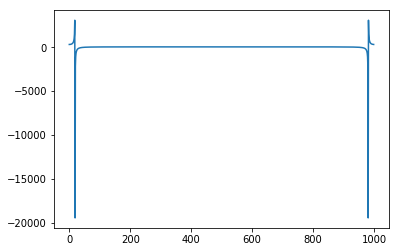

In [7]:
plt.plot(Y)

Chúng ta có thể thấy rằng kết quả trên phép biến đổi *fft *đối xứng với nhau qua trục hoành. <br>
Tương tự, giá trị tuyệt đối (khoảng cách từ gốc tọa độ đến tọa độ của số phức trong mặt phẳng phức) của các phần tử trong mảng **Y** cũng đối xứng qua trục hoành. Chúng ta sử  hàm  `numpy.abs()` để tính giá trị tuyệt đố của số phức.

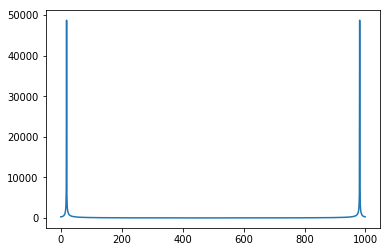

In [8]:
plt.plot(np.abs(Y))

Như chúng ta đã thấy, kêt quả của phép biến đổi **fft** là đối xứng với nhau, nên thông thường chúng ta chỉ cần xét một nửa của kết quả sau phép biến đổi **fft**. Ví dụ như phổ biên độ dưới đây.  

#### Phổ biên độ

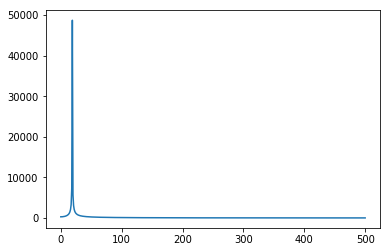

In [9]:
N = len(Y)/2 +1 # Lấy một nửa kết quả của phép biến đổi FFT.
plt.plot(np.abs(Y[:N]))

Biểu diễn trên đây được gọi là **phổ biên độ** (**amplitude spectrum**) của tín hiệu. 

Chúng ta biết rằng, phép biến đổi Fourier giúp biến đổi tín hiệu trên miền thời gian sang miền tần số. Có nghĩa là, sau khi áp dụng phép biến đổi Fourier, chúng ta có thể phân tích được các thành phần tần số  (frequency) tham gia cấu thành tín hiệu và mức độ đóng góp của thành phần tần số đó (amplitute). <br>
Vậy từ kết quả của phép biến đổi **fft**, làm sao chúng ta có thể phân tích được các thông tin trên?

Chúng ta sẽ biểu diễn (visualize) kết quả của phép biến đổi **FFT** trên lên không gian hai chiều, trục hoành biểu diễn tần số, trục tung biểu diễn biên độ.

#### Trục x:  Trục tần số   (Frequency axis)

In [10]:
dt = t[1] - t[0] # khoảng thời gian giữa 2 lần lấy mẫu
fa = 1.0/dt # tần số lấy mẫu
print('dt=%.5fs (Thoi gian)' % dt)
print('fa=%.2fHz (Tan so)' % fa)

dt=0.00629s (Thoi gian)
fa=159.00Hz (Tan so)


Chúng ta cần phải tạo một vector các điểm tần số trong trục tần số tương ứng với $N$ điểm trong kết quả của phép biến đổi FFT, bắt đầu từ $0.0$ và kết thúc tại tần số cực đại `maximum_freq`. Theo định lý [Nyquist](http://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), thì tần số cực đại của tín hiệu, `maximum_freq`,  sẽ bẳng $1/2$ tần số lấy mấu ($f_a$).

In [11]:
X = np.linspace(0, fa/2, N, endpoint=True)
print(X[:4])

[ 0.          0.15899579  0.31799158  0.47698736]


Bây giờ, hãy vẽ lại biễu diễn của FFT trên hai trục tần số và biên độ.

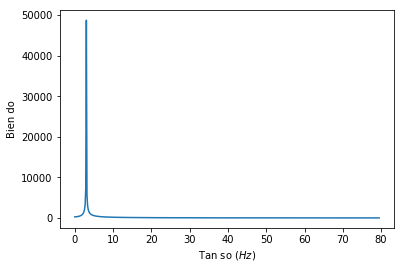

In [12]:
plt.plot(X, np.abs(Y[:N]))
plt.xlabel('Tan so ($Hz$)')
plt.ylabel('Bien do')

Từ hình biểu diễn trên, chúng ta thấy rằng trục tần số trải dài từ $0.0 Hz$ đến $ \dfrac{fa}{2} = 79.5 Hz$. <br>
Biểu diễn trên đạt định ở một điểm tần số duy nhât (3Hz), có nghĩa là tín hiệu trên chỉ được tạo thành từ một thành phần tần số duy nhất. Hãy xem xét lại phương trình dao động của tín hiệu trên $y = 100sin(6\pi t)$

#### Trục y: Trục biên độ

Ở ví dụ trên, chúng ta đã biễu diễn biên độ tại các điểm tần số khách nhau. Tuy nhiên, sự tính toán này chưa thực sự chính xác. Bởi vì chứng ta đã cắt một nửa của biến đổi **FFT**, nên nếu khi thực hiện biến đổi ngược **IFFT**, năng lượng của tín hiệu nhận được khi biến đổi ngược sẽ không bằng năng lượng của tín hiệu gốc. Để đảm bảo năng lượng của tín hiệu trong miền thời gian và miền tần số bằng nhau, chúng ta cần phải nhân đôi biện độ ở một nửa của biến đổi **FFT**. <br>
Hơn nữa, kết quả của phép biến đổi **FFT** thường được chuẩn hóa bằng cách chia cho số lượng mẫu $N$.


$Y[k]=\frac{1}{N} \underbrace{\sum_{N} x(nT)\cdot e^{-i 2 \pi \frac{k}{N}n}}_{DFT}$

Tóm lại, chúng ta cần phải nhân vector biên độ trên 1 nửa của phép biến đổi **FFT** với $\frac{2}{N}$.

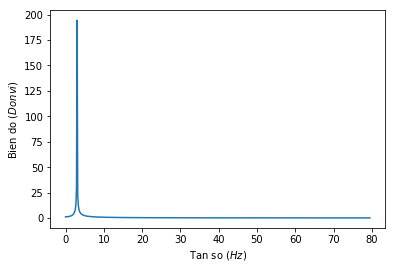

In [13]:
plt.plot(X, 2.0*np.abs(Y[:N])/N)
plt.xlabel('Tan so ($Hz$)')
plt.ylabel('Bien do ($Don vi$)')

Như vậy, chúng ta có thể thấy rằng, đoạn tín hiệu chúng ta đang xem xét được tạo nên từ một thành phần tần số ($3 Hz$) với biên độ gần 200? <br>
Nhưng các bạn có phát hiện ra điều gì bất thường không? Ở bước đầu tiên chúng ta đã đặt biện độ là $A = 100$? Tại sao? 

Lý do dẫn đến sự sai số này là do hiệu ứng Leakage. Hãy xem xét thêm về hiệu ứng Linkage.

#### Hiệu ứng Linkage dẫn đến sự sai số về biên độ

Đầu tiên chúng ta hãy xem lại tín hiệu ban đầu ở miền thời gian

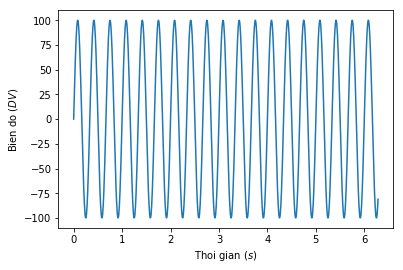

In [14]:
plt.plot(t,s)
plt.xlabel('Thoi gian ($s$)')
plt.ylabel('Bien do ($DV$)')

Các bạn có thầy rằng, tín hiệu ở trên bắt đầu ở $0$ nhưng không kết thúc ở khoảng $-80$ khác $0$? Điều này có nghĩa là, khi chúng ta nối các tín hiệu này lại với nhau, chúng ta sẽ được tín hiệu gãy khúc như hình dưới.

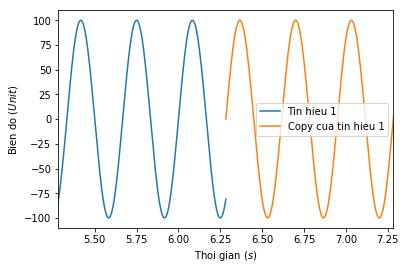

In [15]:
plt.plot(t, s, label='Tin hieu 1')
plt.plot(t+t[-1], s, label='Copy cua tin hieu 1')
plt.xlim(t[-1]-1, t[-1]+1)
plt.xlabel('Thoi gian ($s$)')
plt.ylabel('Bien do ($Unit$)')
plt.legend()

Biến đổi Fourier được phát minh bởi ông Fourier và chỉ dành cho tín hiệu tuần hoàn (xem thêm [Fourier Transform](http://en.wikipedia.org/wiki/Fourier_transform)). và Biến đổi Fourier rời rạc (DFT) hay FFT cũng phải tuần theo điều này.

Tín hiệu cần phải tuần hoàn chặt (strictly periodic), vì vậy trước khi áp dụng biến đổi Fourier, chúng ta thường nhận tín hiệu với các cửa sổ **window** để loại bỏ hiệu ứng Linkage.

#### Các hàm cửa sổ để tạo tín hiệu tuần hoàn

Có nhiều loại hàm cửa sổ, ví dụ như *Hamming*, *Hanning*, *Blackman*, ...

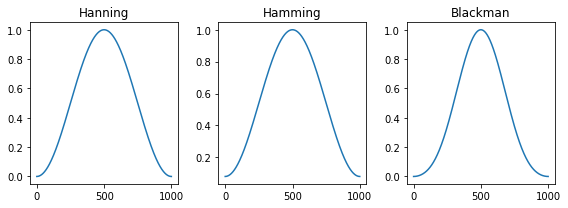

In [16]:
hann = np.hanning(len(s))
hamm = np.hamming(len(s))
black= np.blackman(len(s))

plt.figure(figsize=(8,3))
plt.subplot(131)
plt.plot(hann)
plt.title('Hanning')
plt.subplot(132)
plt.plot(hamm)
plt.title('Hamming')
plt.subplot(133)
plt.plot(black)
plt.title('Blackman')
plt.tight_layout()

[Tham khảo thêm về các hàm cửa sổ](http://en.wikipedia.org/wiki/Window_function). 

Ví dụ chúng ta nhân cửa sổ `hanning` với tín hiệu trên miền thời gian

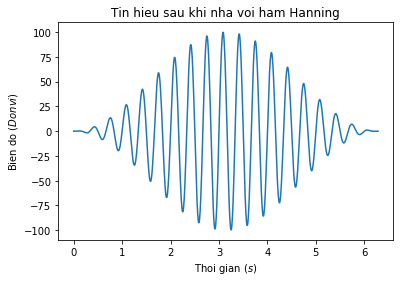

In [17]:
plt.plot(t,hann*s)
plt.xlabel('Thoi gian ($s$)')
plt.ylabel('Bien do ($Don vi$)')
plt.title('Tin hieu sau khi nha voi ham Hanning')

Biến đổi Fourier với tín hiệu sau khi đã chuẩn hóa:

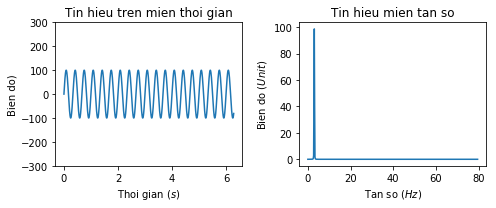

In [18]:
Yhann = np.fft.fft(hann*s)

plt.figure(figsize=(7,3))
plt.subplot(121)
plt.plot(t,s)
plt.title('Tin hieu tren mien thoi gian')
plt.ylim(np.min(s)*3, np.max(s)*3)
plt.xlabel('Thoi gian ($s$)')
plt.ylabel('Bien do)')

plt.subplot(122)
plt.plot(X, 2.0*np.abs(Yhann[:N])/N)
plt.title('Tin hieu mien tan so')
plt.xlabel('Tan so ($Hz$)')
plt.ylabel('Bien do ($Unit$)')

plt.tight_layout()

Đây chính là kết quả mà chúng ta cần phải đạt được.

# 2. Thuật toán DTW (Dynamic Time Warping)

Dynamic time warping (DTW) là một thuật toán dùng để đo độ giống nhau (similarity) giữa hai chuỗi thời gian (time series). Hai chuỗi thời gian có thể khác nhau về độ dài, tốc độ. Ví dụ, hai đoạn âm thanh nói cùng một từ nhưng tốc độ nói có thể khác nhau. 
Về cơ bản thì mục tiêu của thuật toán DTW là tìm một mapping giữa các phần tử trên một chuỗi thời gian với một hoặc nhiều phần tử trên trên chuỗi thời gian kia làm sao để mapping-cost thấp nhất có thể. 

Thuật toán DTW có thể implement dễ dàng bằng phương pháp quy hoạch động. Tuy nhiên, trong gói `librosa` của python mà mình đã sử dụng ở bài trước, thuật toán DTW đã được cài đặt sẵn và bạn chỉ cần gọi hàm [`librosa.core.dtw`](https://librosa.github.io/librosa/generated/librosa.core.dtw.html) với các tham số phù hợp.

Sau đây là một ví dụ sử dụng thuật toán DTW để so sánh hai đoạn âm thanh:

Đầu tiên, chúng ta hãy load một đoạn audio từ thư viện của librosa.

In [19]:
x, sr = librosa.load(librosa.util.example_audio_file(), offset=10, duration=15)
IPython.display.Audio(data = x,rate = sr)

Tiếp theo, chúng ta sẽ thêm nhiễu vào đoạn âm thanh tr

In [20]:
noise = np.random.rand(10000,)
y = np.concatenate((noise, noise, x, noise))
IPython.display.Audio(data = y, rate = sr)

Bây giờ, hãy ứng dụng thuật toán DTW từ thư viện `librosa` để tính độ tượng tự (similarity) giữa file âm thanh và file nhiễu.

Trước tiên, chúng tay cần phải trích chọn đặc trưng cho hai đoạn audio x và y ở trên. Ở đây, mình chọn đặc trưng `chroma` hay `chromagram` - đặc trưng chuyên dùng trong phân tích âm nhạc ( Chúng ta có thể tham khảo các đặc trưng khác [ở đây](https://librosa.github.io/librosa/feature.html) )

In [40]:
# Trích chọn các đặc trưng âm thành chroma từ hai tín hiệu x à y.  
X = librosa.feature.chroma_cens(x, sr = sr)
Y = librosa.feature.chroma_cens(y, sr = sr)

Sau khi có được 2 dãy đặc trưng `mfcc` X và Y như trên, chúng ta sẽ áp dụng thuật toán DTW. Mặc định, `librosa.core.dtw` sẽ sử dụng độ đo `euclidean`. Chúng ta có thể tham khảo thêm các độ đo khác [ở đây](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)

In [41]:
D, wp = librosa.core.dtw(X,Y, subseq = True) # D là ma trận khoảng cách, wp là optimal wraping path.

Hàm [`librosa.core.dtw(args)`](https://librosa.github.io/librosa/generated/librosa.core.dtw.html?highlight=dtw#librosa.core.dtw) sẽ trả về mảng chi phí $D$ và đường đi tôi sưu $wp$ (warping path). 

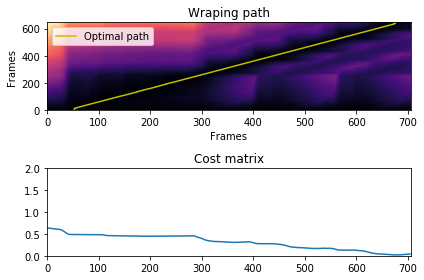

In [42]:
plt.subplot(2, 1, 1)
librosa.display.specshow(D, x_axis='frames', y_axis='frames')
plt.title('Wraping path')
plt.plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(D[-1, :] / wp.shape[0])
plt.xlim([0, Y.shape[1]])
plt.ylim([0, 2])
plt.title('Cost matrix')
plt.tight_layout()